In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import imageio
from scipy.spatial import distance_matrix
import pandas as pd

In [3]:
def create_frame(image, n_colors, verbose=False):

    clustering = KMeans(n_clusters=n_colors)
    clustering = clustering.fit(image.reshape(-1,3))

    if verbose:
        print(clustering.labels_.shape)
        print(clustering.cluster_centers_)

    frame = clustering.cluster_centers_[clustering.labels_]
    frame = frame.reshape(image.shape[0],image.shape[1],3).astype('uint8')

    return frame

In [4]:
def create_gif(image, n_frames):
    
    for i in range(n_frames):
        print(f'Computing frame {i}', end='\r')
        if i == 0:
            frames = np.expand_dims(create_frame(image, i+1), axis=0)
        else:
            frames = np.concatenate([frames, np.expand_dims(create_frame(image, i+1), axis=0)], axis=0)
            
    print('Done computing frames')
            
    return frames

In [5]:
def save_gif(frames, filename, fps):
    with imageio.get_writer(filename, mode='I', fps=fps) as writer:
        for frame in frames:
            writer.append_data(frame)

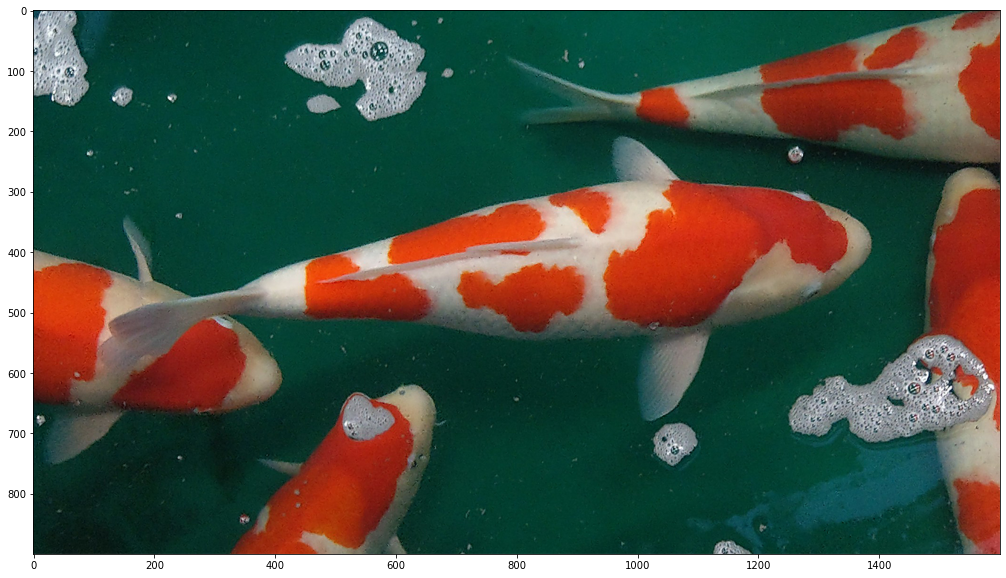

In [24]:
koi = plt.imread('./koi.jpg')
plt.figure(figsize=(20,10))
plt.imshow(koi)

In [7]:
koi.shape

(900, 1600, 3)

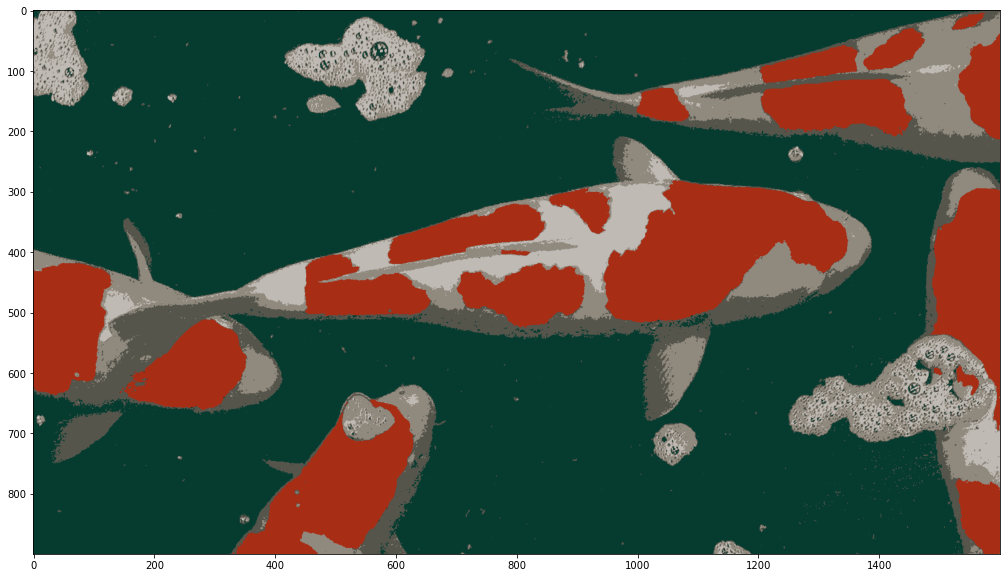

In [8]:
quantized_koi = create_frame(koi, 5)

plt.figure(figsize=(20,10))
plt.imshow(quantized_koi)

In [9]:
gif = create_gif(koi, 15)

gif.shape

Done computing frames


(15, 900, 1600, 3)

In [10]:
save_gif(gif, 'koi.gif', 3)

# Kingfisher

In [25]:
kingfisher = plt.imread('kingfisher.jpg')
save_gif(create_gif(kingfisher, 20), 'kingfisher.gif', 3)

# Linear Interpolation

In [26]:
def get_interpolation_step(clustering1, clustering2, step, total_steps, debug=False):
    
    # if clustering1 has more centers than cluster 2
    if clustering1.cluster_centers_.shape[0] > clustering2.cluster_centers_.shape[0]:
        # swap clusterings
        clustering1, clustering2 = clustering2, clustering1
        
    if not (0 <= step <= total_steps):
        raise ValueError(f'Step number {step} is not in valid range [0,{total_steps}]')
        
    cluster_pairs = []

    start_d = distance_matrix(clustering1.cluster_centers_, clustering2.cluster_centers_)
    d = np.copy(start_d)

    while len(cluster_pairs) < d.shape[0]:

        if debug:
            print(f'Distance Matrix \n\t{d}')

        closest_centers = np.unravel_index(d.argmin(), d.shape)
        
        cluster_pairs.append(closest_centers)

        d[closest_centers[0],:] = 9999999999
        d[:,closest_centers[1]] = 9999999999
        
    if debug:
        print(f'Distance Matrix \n\t{d}')
    
    # allows us to index correctly later using clustering2.labels_
    cluster_pairs.sort(key = lambda x: x[1])
    
    if debug:
            print(f'Cluster Pairs: \n\t{cluster_pairs}')

    for i in range(0,len(clustering2.cluster_centers_)):
        if i >= len(cluster_pairs) or cluster_pairs[i][1] != i:

            closest_center = (np.argmin(start_d[:,i]), i)

            cluster_pairs.insert(i, closest_center)
            
    if debug:
            print(f'Cluster Pairs: \n\t{cluster_pairs}')
    
    start_indecies = [p[0] for p in cluster_pairs]
    end_indecies = [p[1] for p in cluster_pairs]
    
    start = clustering1.cluster_centers_[start_indecies]
    end = clustering2.cluster_centers_[end_indecies]
    
    if debug:
        
        print(f'Start vectors: \n\t{start}')
        print(f'End vectors: \n\t{end}')
    
    interpolation_step = ((end - start) * (step / total_steps)) + start
    return interpolation_step

In [29]:
clustering1 = KMeans(n_clusters=2)
clustering1 = clustering1.fit(kingfisher.reshape(-1,3))

print(clustering1.labels_.shape)
print(clustering1.cluster_centers_)

(1440000,)
[[130.2076925  165.06242416  20.69435336]
 [100.25864011 151.94254044 141.74046321]]


In [30]:
clustering2 = KMeans(n_clusters=3)
clustering2 = clustering2.fit(kingfisher.reshape(-1,3))

print(clustering2.labels_.shape)
print(clustering2.cluster_centers_)

(1440000,)
[[132.43635268 168.57150764  20.64052418]
 [ 40.7443625  104.47556527  99.77688734]
 [188.74112043 196.29124763 171.61273072]]


In [15]:
clustering3 = KMeans(n_clusters=10)
clustering3 = clustering2.fit(kingfisher.reshape(-1,3))

print(clustering3.labels_.shape)
print(clustering3.cluster_centers_)

(1440000,)
[[119.61260723 170.55390143   3.38886585]
 [ 33.47177195 127.84027142 131.00524171]
 [196.01859785 202.10439204 179.4001017 ]
 [ 81.57978306  67.40235392  33.46897676]
 [146.60896907 169.87400022  41.27649504]]


In [16]:
get_interpolation_step(clustering1, clustering3, 1, 2)

array([[124.92272437, 167.8247527 ,  12.03333977],
       [ 66.82969737, 139.81519022, 136.28343012],
       [148.10311032, 176.94725053, 160.48086011],
       [105.90631229, 116.24897894,  27.07339523],
       [138.42090529, 167.48480209,  30.97715436]])

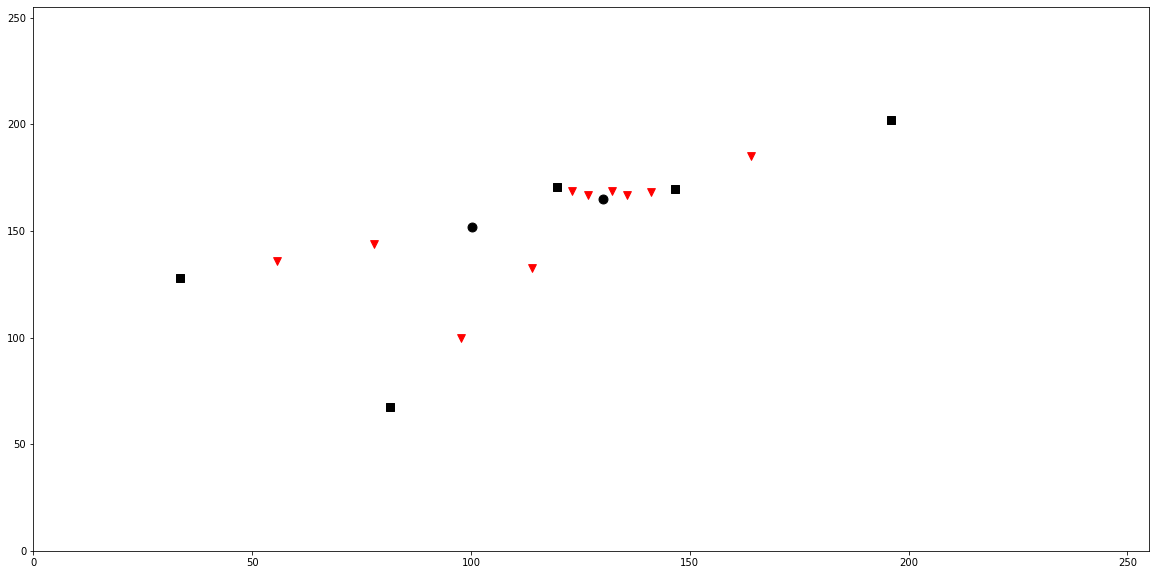

In [17]:
plt.figure(figsize=(20,10))
plt.xlim([0,255])
plt.ylim([0,255])

flat_koi = koi.reshape((-1,3))
#plt.scatter(flat_koi[:,0], flat_koi[:,1], c=flat_koi / 255)

plt.scatter(clustering1.cluster_centers_[:,0], clustering1.cluster_centers_[:,1], color='black', s=80)
plt.scatter(clustering2.cluster_centers_[:,0], clustering2.cluster_centers_[:,1], color='black', s=80, marker='s')
#plt.scatter(clustering3.cluster_centers_[:,0], clustering3.cluster_centers_[:,1], color='black', s=80, marker='+')

step0 = get_interpolation_step(clustering1, clustering3, 0, 3)
step1 = get_interpolation_step(clustering1, clustering3, 1, 3)
step2 = get_interpolation_step(clustering1, clustering3, 2, 3)
step3 = get_interpolation_step(clustering1, clustering3, 3, 3)

plt.scatter(step1[:,0], step1[:,1], color='red', s=60, marker='v')
plt.scatter(step2[:,0], step2[:,1], color='red', s=60, marker='v')


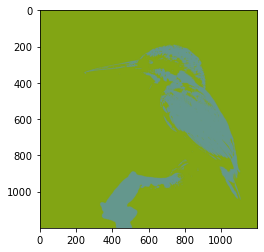

In [18]:
frame = step0[clustering2.labels_].reshape(kingfisher.shape[0],kingfisher.shape[1],3).astype('uint8')

plt.imshow(frame)

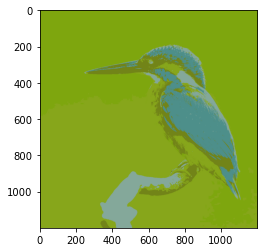

In [19]:
frame = step1[clustering2.labels_].reshape(kingfisher.shape[0],kingfisher.shape[1],3).astype('uint8')

plt.imshow(frame)

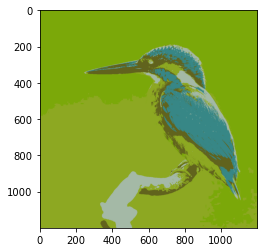

In [20]:
frame = step2[clustering2.labels_].reshape(kingfisher.shape[0],kingfisher.shape[1],3).astype('uint8')

plt.imshow(frame)

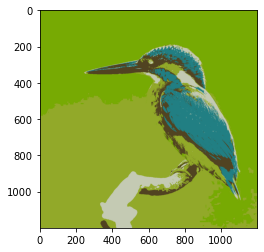

In [21]:
frame = step3[clustering2.labels_].reshape(kingfisher.shape[0],kingfisher.shape[1],3).astype('uint8')

plt.imshow(frame)

# Interpolated Gif

In [29]:
def create_interpolated_gif(image, clusterings, steps_per_clustering):
    
    previous_clustering = None
    frames = None
    
    if isinstance(clusterings, int):
        iterator = np.arange(clusterings)
    elif isinstance(clusterings,list):
        if all(isinstance(x, int) for x in clusterings):
            iterator = clusterings
    
    if debug:
        print(iterator)
    for i in range(len(iterator)):
        
        print(f'Computing frames {i*steps_per_clustering}-{(i+1)*steps_per_clustering - 1} '
              f'of {len(iterator)*steps_per_clustering}', end='\r')
        
        current_clustering = KMeans(n_clusters=iterator[i]+1)
        current_clustering = current_clustering.fit(image.reshape(-1,3))
            
        if previous_clustering is not None:
            for j in range(steps_per_clustering):
                step = get_interpolation_step(previous_clustering, current_clustering, j, steps_per_clustering)
                
                frame = step[current_clustering.labels_]
                frame = frame.reshape(image.shape[0],image.shape[1],3).astype('uint8')
                
                if frames is None:
                    frames = np.expand_dims(frame, axis=0)
                else:
                    frames = np.concatenate([frames, np.expand_dims(frame, axis=0)], axis=0)
    
        previous_clustering = current_clustering
       
    print('Done computing frames                                                              ')
            
    return frames

In [23]:
gif = create_interpolated_gif(koi, 5, 50)
save_gif(gif, 'interpolated_koi.gif', 50)

[0 1 2 3 4]
Done computing frames                                                              


In [26]:
gif = create_interpolated_gif(kingfisher, 10, 60)
save_gif(gif, 'interpolated_kingfisher.gif', 60)

[0 1 2 3 4 5 6 7 8 9]
Done computing frames                                                              


In [28]:
gif = create_interpolated_gif(kingfisher, [0,20], 120)
save_gif(gif, 'interpolated_kingfisher_2_steps.gif', 60)

[0, 20]
Done computing frames                                                              


# Testing

In [18]:
def get_centroid_tree_edges(clustering1, clustering2, debug=False):
    # if clustering1 has more centers than cluster 2
    if clustering1.cluster_centers_.shape[0] > clustering2.cluster_centers_.shape[0]:
        # swap clusterings
        clustering1, clustering2 = clustering2, clustering1

    cluster_pairs = []

    start_d = distance_matrix(clustering1.cluster_centers_, clustering2.cluster_centers_)
    d = np.copy(start_d)

    while len(cluster_pairs) < d.shape[0]:

        if debug:
            print(f'Distance Matrix \n\t{d}')

        closest_centers = np.unravel_index(d.argmin(), d.shape)

        cluster_pairs.append(closest_centers)

        d[closest_centers[0], :] = 9999999999
        d[:, closest_centers[1]] = 9999999999

    if debug:
        print(f'Distance Matrix \n\t{d}')

    # allows us to index correctly later using clustering2.labels_
    cluster_pairs.sort(key=lambda x: x[1])

    if debug:
        print(f'Cluster Pairs: \n\t{cluster_pairs}')

    for i in range(0, len(clustering2.cluster_centers_)):
        if i >= len(cluster_pairs) or cluster_pairs[i][1] != i:
            closest_center = (np.argmin(start_d[:, i]), i)

            cluster_pairs.insert(i, closest_center)

    if debug:
        print(f'Cluster Pairs: \n\t{cluster_pairs}')

    edges = []

    for i in range(len(cluster_pairs)):
        edges.append((f'{len(clustering1.cluster_centers_)}_{cluster_pairs[i][0]}',
                      f'{len(clustering2.cluster_centers_)}_{cluster_pairs[i][1]}',
                     start_d[cluster_pairs[i][0]][cluster_pairs[i][1]]))

    return edges

In [19]:
get_centroid_tree_edges(clustering1, clustering2, debug=True)

Distance Matrix 
	[[ 26.73471789 151.24286144 175.79316082  21.06732401 109.19129537]
 [112.00292578  71.71305086 114.72961334 140.82148192 138.61873949]]
Distance Matrix 
	[[1.00000000e+10 1.00000000e+10 1.00000000e+10 1.00000000e+10
  1.00000000e+10]
 [1.12002926e+02 7.17130509e+01 1.14729613e+02 1.00000000e+10
  1.38618739e+02]]
Distance Matrix 
	[[1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]
 [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]]
Cluster Pairs: 
	[(1, 1), (0, 3)]
Cluster Pairs: 
	[(0, 0), (1, 1), (1, 2), (0, 3), (0, 4)]


[('2_0', '5_0', 26.73471789350148),
 ('2_1', '5_1', 71.7130508591473),
 ('2_1', '5_2', 114.72961333902441),
 ('2_0', '5_3', 21.067324008911505),
 ('2_0', '5_4', 109.19129536895554)]

In [36]:
def get_interpolation_step(clustering1, clustering2, step, total_steps, debug=False):
    
    # if clustering1 has more centers than cluster 2
    if clustering1.cluster_centers_.shape[0] > clustering2.cluster_centers_.shape[0]:
        # swap clusterings
        clustering1, clustering2 = clustering2, clustering1
        
    if not (0 <= step <= total_steps):
        raise ValueError(f'Step number {step} is not in valid range [0,{total_steps}]')
        
    cluster_pairs = []

    start_d = distance_matrix(clustering1.cluster_centers_, clustering2.cluster_centers_)
    d = np.copy(start_d)

    while len(cluster_pairs) < d.shape[0]:

        if debug:
            print(f'Distance Matrix \n\t{d}')

        closest_centers = np.unravel_index(d.argmin(), d.shape)
        
        cluster_pairs.append(closest_centers)

        d[closest_centers[0],:] = 9999999999
        d[:,closest_centers[1]] = 9999999999
        
    if debug:
        print(f'Distance Matrix \n\t{d}')
    
    # allows us to index correctly later using clustering2.labels_
    cluster_pairs.sort(key = lambda x: x[1])
    
    if debug:
            print(f'Cluster Pairs: \n\t{cluster_pairs}')

    for i in range(0,len(clustering2.cluster_centers_)):
        if i >= len(cluster_pairs) or cluster_pairs[i][1] != i:

            closest_center = (np.argmin(start_d[:,i]), i)

            cluster_pairs.insert(i, closest_center)
            
    if debug:
            print(f'Cluster Pairs: \n\t{cluster_pairs}')
    
    start_indecies = [p[0] for p in cluster_pairs]
    end_indecies = [p[1] for p in cluster_pairs]
    
    start = clustering1.cluster_centers_[start_indecies]
    end = clustering2.cluster_centers_[end_indecies]
    
    if debug:
        
        print(f'Start vectors: \n\t{start}')
        print(f'End vectors: \n\t{end}')
    
    interpolation_step = ((end - start) * (step / total_steps)) + start
    return interpolation_step

In [42]:
frames_per_clustering = 50

frames = pd.DataFrame(columns=['R', 'G', 'B', 'frame'])

for i in range(frames_per_clustering):
    steps = get_interpolation_step(clustering1, clustering2, i, frames_per_clustering)
    
    for j in range(steps.shape[0]):
        frames = frames.append({'R': steps[j,0], 'G': steps[j,1], 'B': steps[j,2], 'frame': i}, ignore_index=True)
    
frames

,R,G,B,frame
0,130.207692,165.062424,20.694353,0.0
1,100.258640,151.942540,141.740463,0.0
2,100.258640,151.942540,141.740463,0.0
3,130.252266,165.132606,20.693277,1.0
4,99.068355,150.993201,140.901192,1.0
...,...,...,...,...
145,43.124934,106.374244,101.455430,48.0
146,185.201821,194.517299,170.417840,48.0
147,132.391779,168.501326,20.641601,49.0
148,41.934648,105.424905,100.616159,49.0


# Misc Functions

In [ ]:
def get_centroid_animation_frames(frames_per_clustering):
    frames = pd.DataFrame(columns=['R', 'G', 'B', 'frame', 'centroid'])

    previous_clustering = None
    clusterings_animated = 0
    for k in range(MAX_K + 1):
        if f'clustering_{k}' in st.session_state:
            current_clustering = st.session_state[f'clustering_{k}']
            if previous_clustering is not None:
                for i in range(frames_per_clustering):
                    steps = get_interpolation_step(previous_clustering, current_clustering, i, frames_per_clustering)

                    for j in range(steps.shape[0]):
                        frames = frames.append({'R': steps[j, 0], 'G': steps[j, 1], 'B': steps[j, 2],
                                                'frame': (frames_per_clustering * clusterings_animated) + i,
                                                'centroid': j},
                                               ignore_index=True)
                clusterings_animated += 1

            previous_clustering = current_clustering

    return frames

In [ ]:
def render_centroid_plot():

    centroids = pd.DataFrame(columns=['R', 'G', 'B', 'K', 'size', 'color'])

    def get_size(k):
        return -1 * (math.sqrt(math.pow(MAX_K - 1, 2) - math.pow(k - MAX_K, 2))) + MAX_K

    for k in range(MAX_K):
        if f'clustering_{k}' in st.session_state:
            for color in st.session_state[f'clustering_{k}'].cluster_centers_:
                centroids = centroids.append({'R': color[0], 'G': color[1], 'B': color[2],
                                              'K': k, 'size': get_size(k)}, ignore_index=True)

    centroids['color'] = centroids.apply(row_to_rgb_tuple, axis=1)

    domain = (0, 255)
    fig = px.scatter_3d(centroids, x='R', y='G', z='B',
                        range_x=domain, range_y=domain, range_z=domain,
                        color='color', color_discrete_map='identity',
                        size_max=2 * MAX_K, size='size',
                        hover_data={'K': True, 'R': True, 'G': True, 'B': True, 'size': False})

    st.plotly_chart(fig, use_container_width=True)

In [ ]:
def get_interpolation_step(clustering1, clustering2, step, total_steps, debug=False):
    if not (0 <= step <= total_steps):
        raise ValueError(f'Step number {step} is not in valid range [0,{total_steps}]')

    centroid_pairs, _ = get_centroid_pairs(clustering1, clustering2, True)
    st.write(centroid_pairs)

    start_indices = [p[0] for p in centroid_pairs]
    end_indices = [p[1] for p in centroid_pairs]

    start = clustering1.cluster_centers_[start_indices]
    end = clustering2.cluster_centers_[end_indices]

    if debug:
        print(f'Start vectors: \n\t{start}')
        print(f'End vectors: \n\t{end}')

    interpolation_step = ((end - start) * (step / total_steps)) + start
    return interpolation_step